# Quarterly Vintage Percentile Scenarios

Replaces fixed multiplicative stress/upside shifts with empirical percentiles from per-quarter CDR and CPR distributions.

- **CDR per quarter**: Same trailing 12-month MDR methodology, restricted to loans from that vintage
- **CPR per quarter**: Pool-level SMM→CPR from calc_amort columns, Current loans only
- **Stress**: CDR = P75, CPR = P25
- **Upside**: CDR = P25, CPR = P75
- **Base**: Pool-level CDR/CPR (unchanged)

In [1]:
import sys
import os
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Find project root (directory containing src/ and data/)
# Works whether notebook is in project root, scripts/, or notebooks/
_nb_dir = os.path.abspath('')
_project_root = _nb_dir
for _ in range(5):
    if os.path.isdir(os.path.join(_project_root, 'src')) and os.path.isdir(os.path.join(_project_root, 'data')):
        break
    _project_root = os.path.dirname(_project_root)
else:
    raise RuntimeError(f'Could not find project root (src/ + data/) from {_nb_dir}')

if _project_root not in sys.path:
    sys.path.insert(0, _project_root)
os.chdir(_project_root)
print(f'Project root: {_project_root}')

from src.amortization import calc_amort, calc_monthly_payment, calc_balance
from src.portfolio_analytics import reconstruct_loan_timeline
from src.cashflow_engine import compute_pool_assumptions

pd.set_option('display.float_format', '{:.6f}'.format)
%matplotlib inline
plt.rcParams['figure.dpi'] = 120

Project root: c:\Users\gavro\OneDrive\Desktop\aravalli


## 1. Load and Prepare Data

In [3]:
conn = sqlite3.connect('data/loans.db')
df = pd.read_sql('SELECT * FROM loans', conn)
conn.close()
print(f"Loaded {len(df):,} loans")

for col in ['issue_d', 'last_pymnt_d', 'maturity_month']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

df = calc_amort(df)
df = reconstruct_loan_timeline(df)
print("calc_amort + timeline done")

Loaded 2,255,494 loans
calc_amort + timeline done


In [4]:
SNAPSHOT = pd.Timestamp('2019-03-01')
ACTIVE_STATUSES = ['Current', 'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)']

df['vintage_quarter'] = df['issue_d'].dt.to_period('Q').astype(str)

df_active = df[df['loan_status'].isin(ACTIVE_STATUSES)].copy()
df_current = df_active[
    (df_active['loan_status'] == 'Current') &
    (df_active['last_pymnt_d'] == SNAPSHOT)
].copy()

# For CPR: include Fully Paid loans whose last payment was March 2019.
# These are the biggest prepayment events — full payoffs. Excluding them
# understates prepayment activity. calc_amort's last_pmt_unscheduled_principal
# already captures the full payoff amount correctly.
df_fully_paid_mar = df[
    (df['loan_status'] == 'Fully Paid') &
    (df['last_pymnt_d'] == SNAPSHOT)
].copy()

df_cpr_eligible = pd.concat([df_current, df_fully_paid_mar], ignore_index=True)

print(f"Total: {len(df):,}  |  Active: {len(df_active):,}  |  Current (Mar): {len(df_current):,}")
print(f"Fully Paid (Mar): {len(df_fully_paid_mar):,}  |  CPR eligible: {len(df_cpr_eligible):,}")

Total: 2,255,494  |  Active: 907,755  |  Current (Mar): 821,602
Fully Paid (Mar): 23,199  |  CPR eligible: 844,801


## 2. CDR by Quarterly Vintage

For each quarter, compute CDR using the same trailing 12-month methodology as `compute_pool_assumptions()` — restricted to that vintage's loans only.

Each quarter becomes one data point. A 2007Q4 vintage lived through the crisis and has a different CDR than a 2017Q3 vintage that barely had time to season. That real variation is what drives stress/upside instead of an arbitrary ±15%.

In [5]:
def compute_cdr_for_subset(df_subset: pd.DataFrame) -> dict:
    """Trailing 12-month CDR for a loan subset. Same math as compute_pool_assumptions()."""
    snapshot = pd.Timestamp('2019-03-01')
    issue_dates = pd.to_datetime(df_subset['issue_d'])
    default_month = pd.to_datetime(df_subset['default_month'], errors='coerce')
    payoff_month = pd.to_datetime(df_subset['payoff_month'], errors='coerce')

    monthly_mdrs = []
    for m in range(1, 13):
        month_start = snapshot - pd.DateOffset(months=m)
        month_end = month_start + pd.DateOffset(months=1)

        defaults_mask = (default_month >= month_start) & (default_month < month_end)
        default_upb = (
            df_subset.loc[defaults_mask, 'funded_amnt'] -
            df_subset.loc[defaults_mask, 'total_rec_prncp']
        ).clip(lower=0).sum()

        originated = issue_dates <= month_start
        not_defaulted = default_month.isna() | (default_month > month_start)
        not_paid_off = payoff_month.isna() | (payoff_month > month_start)
        performing_mask = originated & not_defaulted & not_paid_off
        perf_idx = performing_mask.values.nonzero()[0]

        if len(perf_idx) > 0:
            funded = df_subset['funded_amnt'].values[perf_idx].astype(np.float64)
            rates = df_subset['int_rate'].values[perf_idx].astype(np.float64)
            terms = df_subset['term_months'].values[perf_idx].astype(np.float64)

            perf_issue = issue_dates.values[perf_idx]
            td = np.datetime64(month_start) - perf_issue
            age_at_month = np.round(
                td.astype('timedelta64[D]').astype(np.float64) / 30.44
            ).astype(int).clip(min=0)

            # Cap age at term — loans past maturity have zero scheduled balance,
            # and calc_balance iterating past term causes numerical issues
            age_at_month = np.minimum(age_at_month, terms.astype(int))

            pmt = calc_monthly_payment(funded, rates, terms)
            est_bal, _, _ = calc_balance(funded, rates, pmt, age_at_month.astype(np.float64))
            performing_balance = np.clip(est_bal, 0, None).sum()
        else:
            performing_balance = 0.0

        # Clip MDR to [0, 1] — a near-zero performing balance for a mostly
        # run-off vintage can produce MDR >> 1, which explodes under annualization
        mdr = default_upb / performing_balance if performing_balance > 0 else 0.0
        mdr = min(mdr, 1.0)
        monthly_mdrs.append(mdr)

    avg_mdr = float(np.mean(monthly_mdrs))
    cdr = 1 - (1 - avg_mdr) ** 12
    return {'cdr': cdr, 'avg_mdr': avg_mdr, 'n_loans': len(df_subset)}

In [7]:
quarters = sorted(df['vintage_quarter'].dropna().unique())
print(f"{len(quarters)} quarterly vintages: {quarters[0]} – {quarters[-1]}\n")

cdr_rows = []
for q in quarters:
    subset = df[df['vintage_quarter'] == q]
    r = compute_cdr_for_subset(subset)
    cdr_rows.append({'quarter': q, 'cdr': r['cdr'], 'n_loans': r['n_loans']})

cdr_df = pd.DataFrame(cdr_rows).set_index('quarter')
cdr_df.style.format({'cdr': '{:.4%}', 'n_loans': '{:,.0f}'})

47 quarterly vintages: 2007Q2 – 2018Q4



,cdr,n_loans
quarter,,
2007Q2,0.0000%,1
2007Q3,0.0000%,81
2007Q4,0.0000%,169
2008Q1,0.0000%,581
2008Q2,0.0000%,292
2008Q3,0.0000%,186
2008Q4,0.0000%,502
2009Q1,0.0000%,775
2009Q2,0.0000%,962


### Minimum Loan Count Filter

Very small vintages produce unreliable CDRs. Check how percentiles shift with different cutoffs.

In [8]:
for min_n in [0, 100, 500, 1000]:
    filtered = cdr_df[cdr_df['n_loans'] >= min_n]
    p25 = np.percentile(filtered['cdr'], 25)
    p75 = np.percentile(filtered['cdr'], 75)
    print(f"min_n={min_n:>5d}: {len(filtered):>3d} quarters  |  "
          f"P25={p25:.4%}  P50={np.percentile(filtered['cdr'], 50):.4%}  P75={p75:.4%}")

min_n=    0:  47 quarters  |  P25=0.0000%  P50=0.2374%  P75=15.6192%
min_n=  100:  45 quarters  |  P25=0.0000%  P50=1.9613%  P75=15.7418%
min_n=  500:  42 quarters  |  P25=0.0000%  P50=5.6194%  P75=15.9990%
min_n= 1000:  38 quarters  |  P25=0.0000%  P50=11.4551%  P75=16.3592%


In [9]:
# Adjust this after looking at the output above
MIN_LOANS_CDR = 500
cdr_filtered = cdr_df[cdr_df['n_loans'] >= MIN_LOANS_CDR].copy()
print(f"Using {len(cdr_filtered)} quarters with ≥{MIN_LOANS_CDR} loans")

Using 42 quarters with ≥500 loans


### CDR Distribution

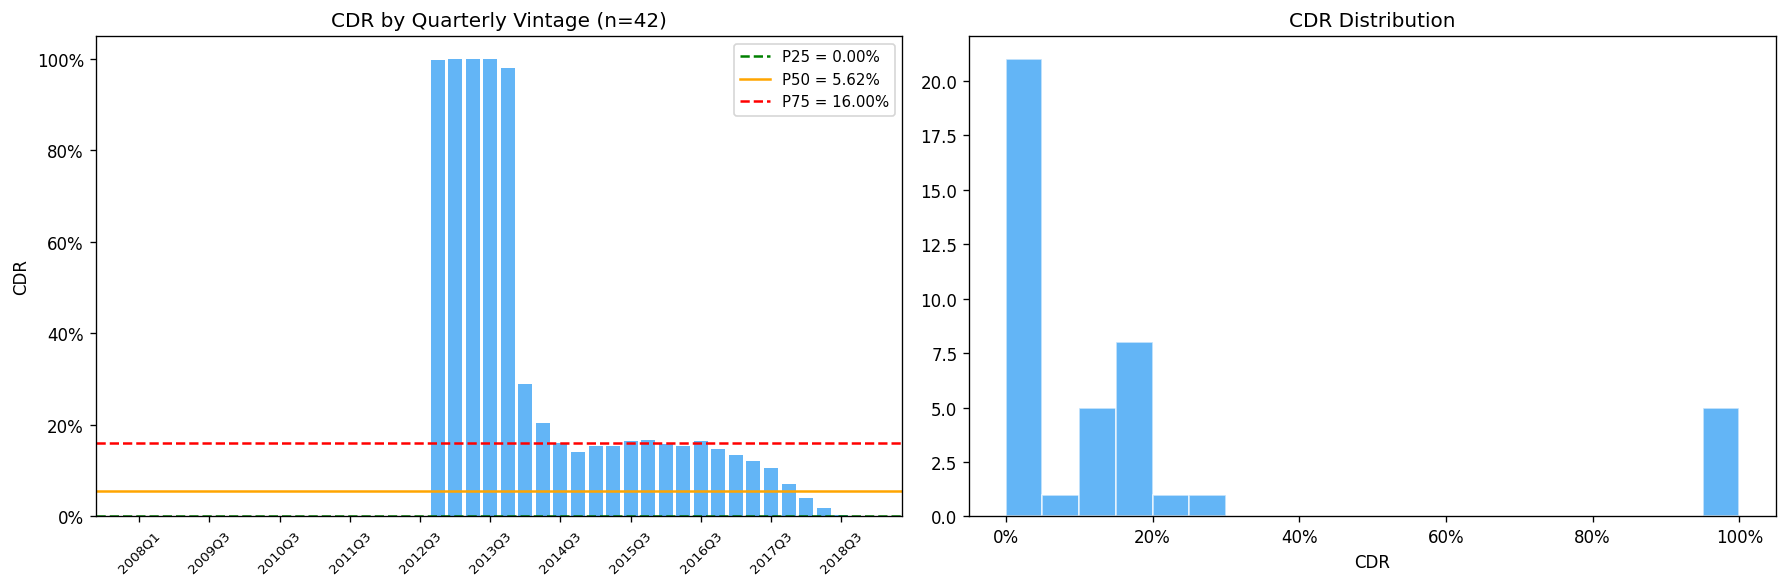

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Time series
ax = axes[0]
ax.bar(range(len(cdr_filtered)), cdr_filtered['cdr'].values, color='#2196F3', alpha=0.7)
tick_idx = list(range(0, len(cdr_filtered), 4))
ax.set_xticks(tick_idx)
ax.set_xticklabels([cdr_filtered.index[i] for i in tick_idx], rotation=45, fontsize=8)
ax.set_ylabel('CDR')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_title(f'CDR by Quarterly Vintage (n={len(cdr_filtered)})')

for p, color, ls in [(25, 'green', '--'), (50, 'orange', '-'), (75, 'red', '--')]:
    val = np.percentile(cdr_filtered['cdr'], p)
    ax.axhline(val, color=color, ls=ls, lw=1.5, label=f'P{p} = {val:.2%}')
ax.legend(fontsize=9)

# Histogram
ax = axes[1]
ax.hist(cdr_filtered['cdr'].values, bins=min(20, len(cdr_filtered) // 2),
        edgecolor='white', color='#2196F3', alpha=0.7)
ax.set_xlabel('CDR')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_title('CDR Distribution')

plt.tight_layout()
plt.show()

In [11]:
print("CDR Percentiles (quarterly vintage):")
for p in [10, 25, 50, 75, 90]:
    print(f"  P{p:2d}: {np.percentile(cdr_filtered['cdr'], p):.4%}")

CDR Percentiles (quarterly vintage):
  P10: 0.0000%
  P25: 0.0000%
  P50: 5.6194%
  P75: 15.9990%
  P90: 91.1821%


## 3. CPR by Quarterly Vintage

For each quarter's CPR-eligible loans (March 2019 payment), aggregate the calc_amort columns and compute pool-level SMM → CPR.

**CPR-eligible** = Current loans with last payment March 2019 **+ Fully Paid loans whose last payment was March 2019**. The Fully Paid loans are the biggest prepayment events — they paid off the entire remaining balance in one shot. Excluding them would understate prepayment activity.

Delinquent loans are still excluded — they're behind on payments, not prepaying.

In [12]:
def compute_pool_cpr_for_subset(df_cpr_subset: pd.DataFrame) -> dict:
    """
    Pool-level CPR from CPR-eligible loans (Current + Fully Paid, March 2019).
    Same SMM→CPR math as compute_pool_assumptions().
    """
    paid = df_cpr_subset[df_cpr_subset['last_pmt_beginning_balance'] > 0]
    if len(paid) == 0:
        return {'cpr': 0.0, 'smm': 0.0, 'n_loans': 0}

    total_beg_bal = paid['last_pmt_beginning_balance'].sum()
    total_sched = paid['last_pmt_scheduled_principal'].sum()
    total_unsched = paid['last_pmt_unscheduled_principal'].sum()

    denom = total_beg_bal - total_sched
    if denom > 0:
        smm = total_unsched / denom
        cpr = 1 - (1 - smm) ** 12
    else:
        smm = 0.0
        cpr = 0.0

    return {'cpr': cpr, 'smm': smm, 'n_loans': len(paid)}

In [13]:
cpr_rows = []
for q in quarters:
    subset = df_cpr_eligible[df_cpr_eligible['vintage_quarter'] == q]
    r = compute_pool_cpr_for_subset(subset)
    cpr_rows.append({'quarter': q, 'cpr': r['cpr'], 'smm': r['smm'], 'n_loans': r['n_loans']})

cpr_df = pd.DataFrame(cpr_rows).set_index('quarter')
cpr_df.style.format({'cpr': '{:.4%}', 'smm': '{:.6f}', 'n_loans': '{:,.0f}'})

,cpr,smm,n_loans
quarter,,,
2007Q2,0.0000%,0.000000,0
2007Q3,0.0000%,0.000000,0
2007Q4,0.0000%,0.000000,0
2008Q1,0.0000%,0.000000,0
2008Q2,0.0000%,0.000000,0
2008Q3,0.0000%,0.000000,0
2008Q4,0.0000%,0.000000,0
2009Q1,0.0000%,0.000000,0
2009Q2,0.0000%,0.000000,0


In [14]:
for min_n in [0, 20, 50, 100]:
    filtered = cpr_df[cpr_df['n_loans'] >= min_n]
    if len(filtered) > 0:
        p25 = np.percentile(filtered['cpr'], 25)
        p75 = np.percentile(filtered['cpr'], 75)
        print(f"min_n={min_n:>4d}: {len(filtered):>3d} quarters  |  "
              f"P25={p25:.4%}  P50={np.percentile(filtered['cpr'], 50):.4%}  P75={p75:.4%}")

min_n=   0:  47 quarters  |  P25=0.0000%  P50=0.0000%  P75=14.4926%
min_n=  20:  20 quarters  |  P25=11.4670%  P50=16.1128%  P75=19.6367%
min_n=  50:  20 quarters  |  P25=11.4670%  P50=16.1128%  P75=19.6367%
min_n= 100:  20 quarters  |  P25=11.4670%  P50=16.1128%  P75=19.6367%


In [17]:
MIN_LOANS_CPR = 1000
cpr_filtered = cpr_df[cpr_df['n_loans'] >= MIN_LOANS_CPR].copy()
print(f"Using {len(cpr_filtered)} quarters with ≥{MIN_LOANS_CPR} Current loans")

Using 19 quarters with ≥1000 Current loans


### CPR Distribution

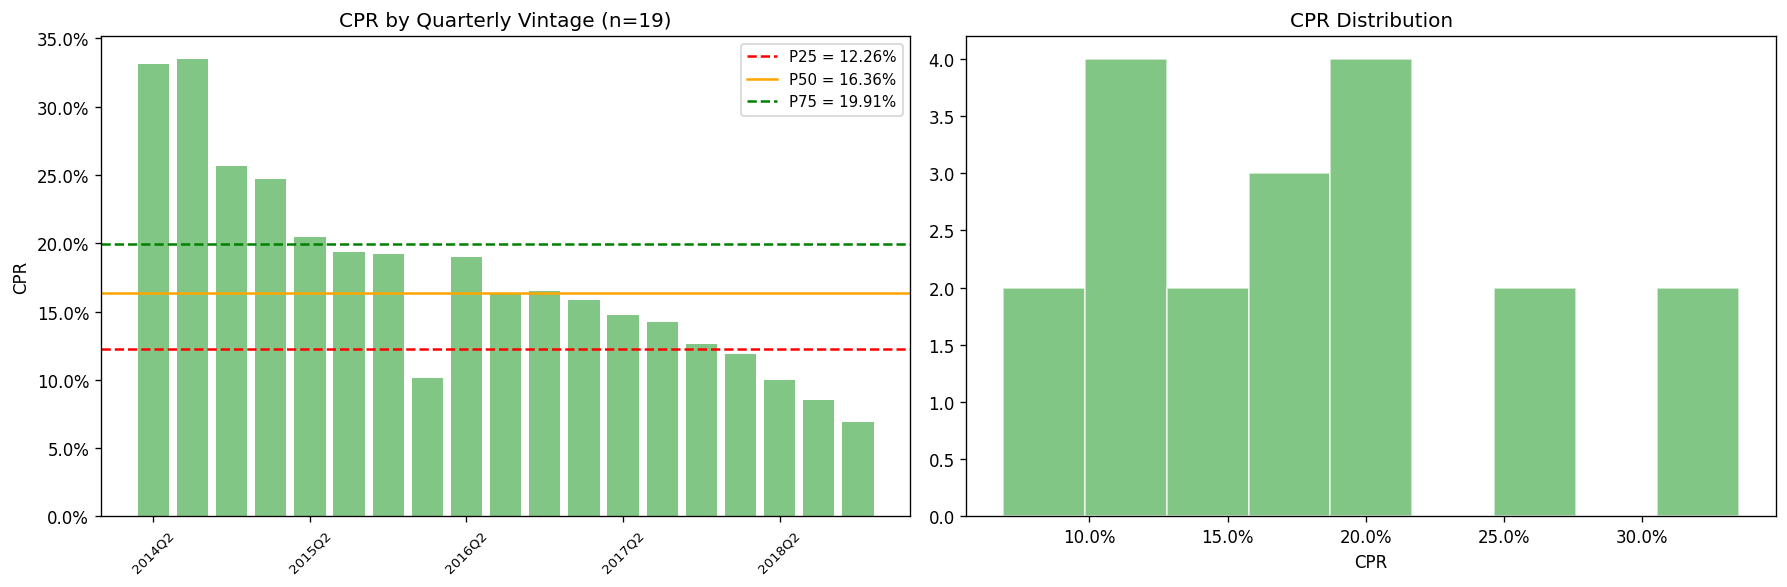

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ax = axes[0]
ax.bar(range(len(cpr_filtered)), cpr_filtered['cpr'].values, color='#4CAF50', alpha=0.7)
tick_idx = list(range(0, len(cpr_filtered), 4))
ax.set_xticks(tick_idx)
ax.set_xticklabels([cpr_filtered.index[i] for i in tick_idx], rotation=45, fontsize=8)
ax.set_ylabel('CPR')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_title(f'CPR by Quarterly Vintage (n={len(cpr_filtered)})')

for p, color, ls in [(25, 'red', '--'), (50, 'orange', '-'), (75, 'green', '--')]:
    val = np.percentile(cpr_filtered['cpr'], p)
    ax.axhline(val, color=color, ls=ls, lw=1.5, label=f'P{p} = {val:.2%}')
ax.legend(fontsize=9)

ax = axes[1]
ax.hist(cpr_filtered['cpr'].values, bins=min(20, len(cpr_filtered) // 2),
        edgecolor='white', color='#4CAF50', alpha=0.7)
ax.set_xlabel('CPR')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_title('CPR Distribution')

plt.tight_layout()
plt.show()

In [19]:
print("CPR Percentiles (quarterly vintage, Current loans only):")
for p in [10, 25, 50, 75, 90]:
    print(f"  P{p:2d}: {np.percentile(cpr_filtered['cpr'], p):.4%}")

CPR Percentiles (quarterly vintage, Current loans only):
  P10: 9.6956%
  P25: 12.2636%
  P50: 16.3553%
  P75: 19.9144%
  P90: 27.1558%


## 4. Comparison: Multiplicative vs Percentile Scenarios

Side-by-side comparison of the current ±15% approach and quarterly vintage P25/P75.

In [21]:
pool = compute_pool_assumptions(df, df_active)
base_cdr = pool['cdr']
base_cpr = pool['cpr']
base_ls = pool['loss_severity']

stress_pct = 0.15

mult_stress_cdr = base_cdr * (1 + stress_pct)
mult_upside_cdr = base_cdr * (1 - stress_pct)
mult_stress_cpr = base_cpr * (1 - stress_pct)
mult_upside_cpr = base_cpr * (1 + stress_pct)

pctl_stress_cdr = np.percentile(cdr_filtered['cdr'], 75)
pctl_upside_cdr = np.percentile(cdr_filtered['cdr'], 25)
pctl_stress_cpr = np.percentile(cpr_filtered['cpr'], 25)
pctl_upside_cpr = np.percentile(cpr_filtered['cpr'], 75)

In [22]:
print(f"{'':30s} {'Stress':>10s} {'Base':>10s} {'Upside':>10s} {'Range':>10s}")
print("=" * 72)
print(f"{'CDR — Multiplicative (±15%)':<30s} {mult_stress_cdr:>10.2%} {base_cdr:>10.2%} {mult_upside_cdr:>10.2%} {mult_stress_cdr - mult_upside_cdr:>10.2%}")
print(f"{'CDR — Quarterly P25/P75':<30s} {pctl_stress_cdr:>10.2%} {base_cdr:>10.2%} {pctl_upside_cdr:>10.2%} {pctl_stress_cdr - pctl_upside_cdr:>10.2%}")
print()
print(f"{'CPR — Multiplicative (±15%)':<30s} {mult_stress_cpr:>10.2%} {base_cpr:>10.2%} {mult_upside_cpr:>10.2%} {mult_upside_cpr - mult_stress_cpr:>10.2%}")
print(f"{'CPR — Quarterly P25/P75':<30s} {pctl_stress_cpr:>10.2%} {base_cpr:>10.2%} {pctl_upside_cpr:>10.2%} {pctl_upside_cpr - pctl_stress_cpr:>10.2%}")
print()
print(f"Loss severity (fixed): {base_ls:.2%}")

                                   Stress       Base     Upside      Range
CDR — Multiplicative (±15%)         8.81%      7.66%      6.51%      2.30%
CDR — Quarterly P25/P75            16.00%      7.66%      0.00%     16.00%

CPR — Multiplicative (±15%)         1.26%      1.49%      1.71%      0.45%
CPR — Quarterly P25/P75            12.26%      1.49%     19.91%      7.65%

Loss severity (fixed): 89.17%


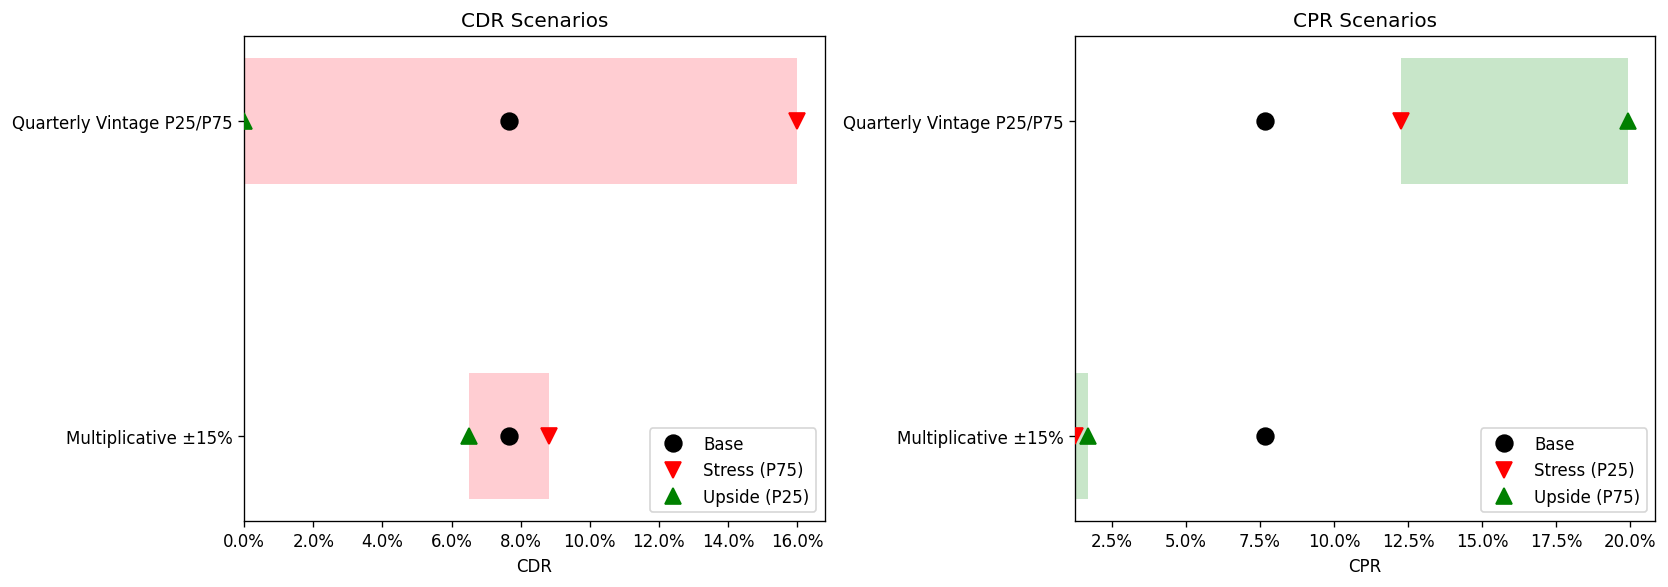

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

labels = ['Multiplicative ±15%', 'Quarterly Vintage P25/P75']
y = [0, 1]

# CDR
ax = axes[0]
stress_vals = [mult_stress_cdr, pctl_stress_cdr]
base_vals = [base_cdr, base_cdr]
upside_vals = [mult_upside_cdr, pctl_upside_cdr]

for i in range(2):
    ax.barh(i, stress_vals[i] - upside_vals[i], left=upside_vals[i],
            color='#ffcdd2', height=0.4)
    ax.plot(base_vals[i], i, 'ko', ms=10, zorder=5)
    ax.plot(stress_vals[i], i, 'rv', ms=10, zorder=5)
    ax.plot(upside_vals[i], i, 'g^', ms=10, zorder=5)

ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_title('CDR Scenarios')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_xlabel('CDR')
ax.legend(['Base', 'Stress (P75)', 'Upside (P25)'], loc='lower right')

# CPR
ax = axes[1]
stress_vals = [mult_stress_cpr, pctl_stress_cpr]
upside_vals = [mult_upside_cpr, pctl_upside_cpr]

for i in range(2):
    low = min(stress_vals[i], upside_vals[i])
    high = max(stress_vals[i], upside_vals[i])
    ax.barh(i, high - low, left=low, color='#c8e6c9', height=0.4)
    ax.plot(base_vals[i], i, 'ko', ms=10, zorder=5)
    ax.plot(stress_vals[i], i, 'rv', ms=10, zorder=5)
    ax.plot(upside_vals[i], i, 'g^', ms=10, zorder=5)

ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_title('CPR Scenarios')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_xlabel('CPR')
ax.legend(['Base', 'Stress (P25)', 'Upside (P75)'], loc='lower right')

plt.tight_layout()
plt.show()

## 5. By Grade — How Percentiles Shift Within Strata

When the dashboard filters by grade, percentiles come from that grade's vintage distribution. Higher-grade pools should have tighter CDR ranges.

In [24]:
grades = sorted(df['grade'].dropna().unique())
grade_table = []

for g in grades:
    df_g = df[df['grade'] == g]
    df_g_cpr = df_cpr_eligible[df_cpr_eligible['grade'] == g]
    df_g_active = df_active[df_active['grade'] == g]

    # Pool-level base
    if len(df_g_active) > 0:
        pool_g = compute_pool_assumptions(df_g, df_g_active)
    else:
        pool_g = {'cdr': 0.0, 'cpr': 0.0}

    # Per-quarter CDR
    g_cdrs = []
    for q in quarters:
        sub = df_g[df_g['vintage_quarter'] == q]
        if len(sub) >= MIN_LOANS_CDR:
            g_cdrs.append(compute_cdr_for_subset(sub)['cdr'])

    # Per-quarter CPR (Current + Fully Paid March 2019)
    g_cprs = []
    for q in quarters:
        sub = df_g_cpr[df_g_cpr['vintage_quarter'] == q]
        if len(sub) >= MIN_LOANS_CPR:
            r = compute_pool_cpr_for_subset(sub)
            if r['n_loans'] > 0:
                g_cprs.append(r['cpr'])

    row = {
        'Grade': g,
        'Pool CDR': pool_g['cdr'],
        'Pool CPR': pool_g['cpr'],
        'CDR n_qtrs': len(g_cdrs),
        'CPR n_qtrs': len(g_cprs),
    }
    if len(g_cdrs) >= 3:
        row['CDR P25'] = np.percentile(g_cdrs, 25)
        row['CDR P75'] = np.percentile(g_cdrs, 75)
    if len(g_cprs) >= 3:
        row['CPR P25'] = np.percentile(g_cprs, 25)
        row['CPR P75'] = np.percentile(g_cprs, 75)

    grade_table.append(row)

grade_df = pd.DataFrame(grade_table).set_index('Grade')

In [25]:
# Formatted table
display_df = grade_df.copy()
for c in ['Pool CDR', 'Pool CPR', 'CDR P25', 'CDR P75', 'CPR P25', 'CPR P75']:
    if c in display_df.columns:
        display_df[c] = display_df[c].apply(lambda x: f'{x:.2%}' if pd.notna(x) else '—')
display_df

,Pool CDR,Pool CPR,CDR n_qtrs,CPR n_qtrs,CDR P25,CDR P75,CPR P25,CPR P75
Grade,,,,,,,,
A,1.66%,1.78%,35,12,0.00%,4.25%,9.88%,21.33%
B,4.56%,1.51%,37,17,0.00%,9.62%,11.63%,19.00%
C,8.30%,1.26%,35,18,0.00%,15.23%,11.71%,20.78%
D,12.12%,1.31%,32,18,0.00%,20.94%,11.42%,19.02%
E,18.67%,1.66%,28,15,10.06%,26.97%,12.58%,17.21%
F,25.36%,2.77%,23,0,19.44%,35.26%,—,—
G,32.06%,0.93%,11,0,26.22%,37.84%,—,—


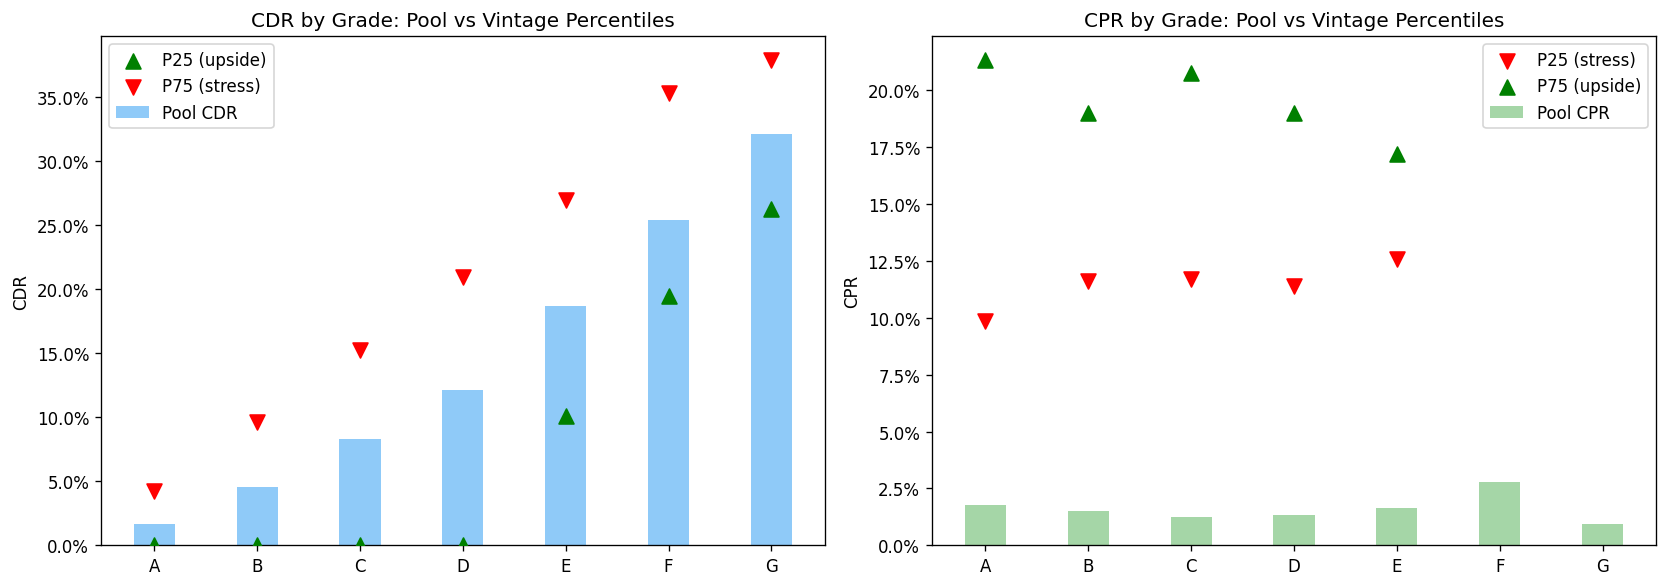

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
x = np.arange(len(grades))

# CDR by grade
ax = axes[0]
ax.bar(x, grade_df['Pool CDR'].values, width=0.4, color='#2196F3', alpha=0.5, label='Pool CDR')
if 'CDR P25' in grade_df.columns:
    ax.scatter(x, grade_df['CDR P25'].values, color='green', marker='^', s=80, zorder=5, label='P25 (upside)')
    ax.scatter(x, grade_df['CDR P75'].values, color='red', marker='v', s=80, zorder=5, label='P75 (stress)')
ax.set_xticks(x)
ax.set_xticklabels(grades)
ax.set_ylabel('CDR')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_title('CDR by Grade: Pool vs Vintage Percentiles')
ax.legend()

# CPR by grade
ax = axes[1]
ax.bar(x, grade_df['Pool CPR'].values, width=0.4, color='#4CAF50', alpha=0.5, label='Pool CPR')
if 'CPR P25' in grade_df.columns:
    ax.scatter(x, grade_df['CPR P25'].values, color='red', marker='v', s=80, zorder=5, label='P25 (stress)')
    ax.scatter(x, grade_df['CPR P75'].values, color='green', marker='^', s=80, zorder=5, label='P75 (upside)')
ax.set_xticks(x)
ax.set_xticklabels(grades)
ax.set_ylabel('CPR')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_title('CPR by Grade: Pool vs Vintage Percentiles')
ax.legend()

plt.tight_layout()
plt.show()

## 6. Edge Cases

Check for vintages that might distort the percentiles — zeros, tiny sample sizes, very old or very new quarters.

In [ ]:
print("VINTAGES WITH ZERO CDR:")
zero_cdr = cdr_df[cdr_df['cdr'] == 0]
if len(zero_cdr) > 0:
    print(zero_cdr.to_string(formatters={'cdr': '{:.4%}'.format, 'n_loans': '{:,.0f}'.format}))
else:
    print("  (none)")

print(f"\nVINTAGES WITH ZERO CPR:")
zero_cpr = cpr_df[cpr_df['cpr'] == 0]
if len(zero_cpr) > 0:
    print(zero_cpr.to_string(formatters={'cpr': '{:.4%}'.format, 'n_loans': '{:,.0f}'.format}))
else:
    print("  (none)")

print(f"\nVINTAGES WITH <{MIN_LOANS_CDR} LOANS (excluded from CDR):")
excluded = cdr_df[cdr_df['n_loans'] < MIN_LOANS_CDR]
if len(excluded) > 0:
    print(excluded.to_string(formatters={'cdr': '{:.4%}'.format, 'n_loans': '{:,.0f}'.format}))
else:
    print("  (none)")

print(f"\nOLDEST VINTAGES (fully run off?):")
for q in cdr_filtered.index[:4]:
    print(f"  {q}: CDR={cdr_filtered.loc[q, 'cdr']:.4%}  n={cdr_filtered.loc[q, 'n_loans']:,.0f}")

print(f"\nNEWEST VINTAGES (barely seasoned?):")
for q in cdr_filtered.index[-4:]:
    print(f"  {q}: CDR={cdr_filtered.loc[q, 'cdr']:.4%}  n={cdr_filtered.loc[q, 'n_loans']:,.0f}")

## 7. Summary

In [ ]:
print("=" * 70)
print("QUARTERLY VINTAGE PERCENTILE SCENARIOS")
print("=" * 70)
print(f"""
DATA POINTS:
  CDR: {len(cdr_filtered)} quarters (≥{MIN_LOANS_CDR} loans each)
  CPR: {len(cpr_filtered)} quarters (≥{MIN_LOANS_CPR} Current loans each)

POOL-LEVEL BASE:
  CDR: {base_cdr:.4%}
  CPR: {base_cpr:.4%}
  Loss Severity: {base_ls:.4%}

PERCENTILE SCENARIOS:
  Stress — CDR P75: {pctl_stress_cdr:.4%}   CPR P25: {pctl_stress_cpr:.4%}
  Base   — CDR:     {base_cdr:.4%}   CPR:     {base_cpr:.4%}
  Upside — CDR P25: {pctl_upside_cdr:.4%}   CPR P75: {pctl_upside_cpr:.4%}

vs MULTIPLICATIVE ±15%:
  Stress — CDR: {mult_stress_cdr:.4%}   CPR: {mult_stress_cpr:.4%}
  Base   — CDR: {base_cdr:.4%}   CPR: {base_cpr:.4%}
  Upside — CDR: {mult_upside_cdr:.4%}   CPR: {mult_upside_cpr:.4%}

CDR RANGE:  Percentile {pctl_stress_cdr - pctl_upside_cdr:.4%}  vs  Multiplicative {mult_stress_cdr - mult_upside_cdr:.4%}
CPR RANGE:  Percentile {pctl_upside_cpr - pctl_stress_cpr:.4%}  vs  Multiplicative {mult_upside_cpr - mult_stress_cpr:.4%}
""")